# Mini-lab 1: Zillow Dataset Logistic Regression and SVMs  
MSDS 7331 Data Mining - Section 403 - Mini Lab 1

Team: Ivelin Angelov, Yao Yao, Kaitlin Kirasich, Albert Asuncion

<a id="top"></a>
## Contents
* <a href="#Imports">Imports</a>
* <a href="#Models">Models</a>
* <a href="#Advantages">Advantages of Each Model</a>
* <a href="#Feature">Feature Importance</a>
* <a href="#Insights">Insights</a>
________________________________________________________________________________________________________

<a id="Imports"></a>

# Imports
We chose to use the same Zillow dataset from Lab 1. For origin and purpose of dataset as well as a detailed description of the dataset, refer to https://github.com/post2web/data_mining_group_project/blob/master/notebooks/lab1.ipynb.

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

# Load Data, Create y and X
We will use the Zillow dataset from our previous lab, where the cleanup files were exported from lab 1 into mini-lab 1. Note that for logistic regression and support vector classifier models, we choose to use mostly complete continuous variables as well as create dummy variables for nominal variables to cross compare the performance, feature importance, and insights of each model. X is the training set and y is the test set, where we are testing if our models can accurately predict positive logerrror from that of negative. 

Data columns that are only available for the training set and not the test set (transaction date) were removed. Parcelid was removed because each individual property has its own ID and does not correlate well with regression or SVMs. The column that was created for "New Features" from Lab 1 (city and pricepersqft) were also removed for the sake of simplicity of only using original data for the prediction process.

In [11]:
# load datasets here:
variables = pd.read_csv('../datasets/variables.csv').set_index('name')
X = pd.read_csv('../datasets/train.csv', low_memory=False)

y = (X['logerror'] > 0).astype(np.int32)

del X['logerror']
del X['transactiondate']
del X['parcelid']
del X['city']
# TODO fix me
del X['price_per_sqft']

'The dataset has %d rows and %d columns' % X.shape

'The dataset has 116761 rows and 49 columns'

# Dealing with Nominal Data
Nominal data ususally has more than two values. For logistic regression and SVMs, we created dummy variables that only factor in 0s and 1s for the prediction process of logistic regression and SVMs.

In [12]:
nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(X.columns)]
nominal_data = X[nominal.index]

nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

# Dealing with Continuous Data
StandardScaler from sklean was applied to the continuous data columns to standardize the dataset around center 0 with equal variance for creating normal distribtions prior to the application of logistic regressio and SVMs.

In [13]:
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(X.columns)]

continuous_data = X[continuous.index]

## Merge the data
The data was then merged for the application of logistic regression and SVM prediction. The following shows the final shape of the dataset after the application of dummy variables and StandardScaler.

In [14]:
X = pd.concat([continuous_data, nominal_data], axis=1)

columns = X.columns

'The dataset has %d rows and %d columns' % X.shape

'The dataset has 116761 rows and 2107 columns'

<a id="Models"></a>
<a href="#top">Back to Top</a>
# Models

<b>[50 points]</b>

<i>
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate</b>. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 
</i>

## Logistic Regression
For the logistic regression model, we created a function that took in X_train and Y_train from the original data set to test for X_test from the modified dataset. The accuracy of the logistic regression prediction for positive or negative logerror was compared with that of the original, where a confusion matrix was made to show percentage accuracy. Due to the complexity of the dataset, we are slightly better than 50% accuracy.

In [17]:
def logistic_regression_model(X_train, y_train, X_test, **params):
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # takes about 1 minute
    params['n_iter'] = 1
    params['loss'] = 'log'
    params['alpha'] = 1.55
    params['epsilon'] = 0.00033
    clf = SGDClassifier(**params)
    # this takes too long
    #clf = SVC(kernel='linear')
    #clf = LinearSVC(**params)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf

yhat, _ = logistic_regression_model(X_train=X, y_train=y, X_test=X)

accuracy = float(sum(yhat==y)) / len(y)
print('Percentage accuracy: %.12f' % (accuracy))

pd.DataFrame(confusion_matrix(y, yhat),
    columns=['Predicted 1', 'Predicted 0'],
    index=['Actual 1', 'Actual 0'],
)

Percentage accuracy: 0.551922302824


,Predicted 1,Predicted 0
Actual 1,0,52318
Actual 0,0,64443


By running logistic regression one time with the built in parameters, we got an accuracy of 0.59.  To try to improve this, we want to do a few things. 

First, we want to do the 80/20 split 5 times and average those results to get a better accuracy.  By splitting the training and test sets up multiple times, we can minimize the effects of outliers.

Second, we want to see how changing the value of alpha and epsilon will effect the accuracy. To do this we have another for loop which sets alpha and epsilon at 10 linear increments from 0.0001 to 2 and 0.00001 to .001, respectively.

We found that the optimal value for alpha is 1.55 and that for epsilon is 0.00033

# to do: make the optimal values into a function

Final average accuracy: 0.525123110521
Final average accuracy: 0.539134158352
Final average accuracy: 0.543944389729
Final average accuracy: 0.545469532822
Final average accuracy: 0.546523358883
Final average accuracy: 0.547374355900
Final average accuracy: 0.547733848817
Final average accuracy: 0.547746542200
Final average accuracy: 0.547034166441
Final average accuracy: 0.546124266690


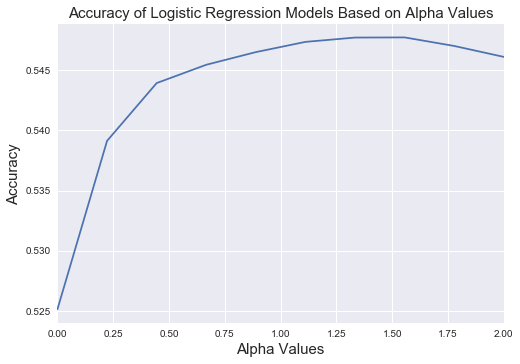

In [14]:
n_splits = 5           # number of times we will split test and training dataset
accuracies = []        # array to hold accuracy to take average of at the end
final_accuracies = {}  # list of final accuracies

# For each value of alpha, find optimal for each train/ test split run logistic regression
for testable in np.linspace(0.0001, 2, 10):
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = logistic_regression_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            alpha=testable
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy: %.12f' % (np.mean(accuracies)))
    final_accuracies[testable] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

# Plot the final accuracy for each value of Alpha
plt.title('Accuracy of Logistic Regression Models Based on Alpha Values', fontsize=15)
plt.xlabel('Alpha Values', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot();

Final average accuracy: 0.508988138569
Final average accuracy: 0.513929687835
Final average accuracy: 0.519259481294
Final average accuracy: 0.522112790648
Final average accuracy: 0.521072239113
Final average accuracy: 0.521451919097
Final average accuracy: 0.520456839439
Final average accuracy: 0.520574444397
Final average accuracy: 0.520436584403
Final average accuracy: 0.521318031945


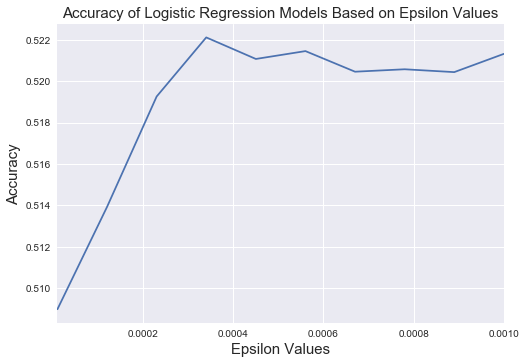

In [17]:
n_splits = 5           # number of times we will split test and training dataset
accuracies = []        # array to hold accuracy to take average of at the end
final_accuracies = {}  # list of final accuracies

# For each value of epsilon, find optimal for each train/ test split run logistic regression
for testable in np.linspace(0.00001, .001, 10):
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = logistic_regression_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            epsilon=testable
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy: %.12f' % (np.mean(accuracies)))
    final_accuracies[testable] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

# Plot the final accuracy for each value of Epsilon
plt.title('Accuracy of Logistic Regression Models Based on Epsilon Values', fontsize=15)
plt.xlabel('Epsilon Values', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot();

# L1 VS L2
We further compared accuracy based on L1 or L2 penalty, where we found L1, the error, is slightly more accurate than L2, the squared error. Which is interesting because typically L2 is better for minimizing error than L1. We think this is because we have about 2000 variables and did not go through and check if every one made sense.  Since L1 acts as a built in feature selection by giving weights nearly 0, this could be why our L1 is better than L2.  This is also a concern for overfitting the model but we will continue as our metric goal here is to maximize accuracy.

Final average accuracy for l1 : 0.516871494026
Final average accuracy for l2 : 0.512214704749


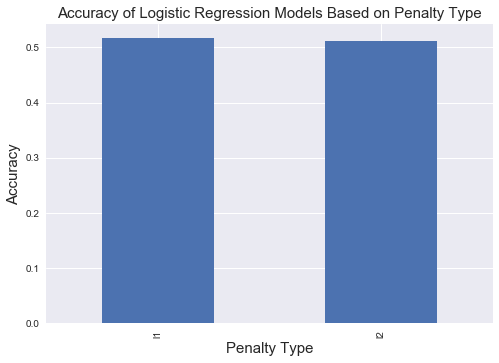

In [18]:
n_splits = 2
accuracies = []
final_accuracies = {}

for penalty in ['l1', 'l2']:
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = logistic_regression_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            penalty=penalty
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy for %s : %.12f' % (penalty, np.mean(accuracies)))
    final_accuracies[penalty] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

plt.title('Accuracy of Logistic Regression Models Based on Penalty Type', fontsize=15)
plt.xlabel('Penalty Type', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot(kind='bar');

## Support Vector Machine Classifier
For the support vector machine model, we created a function that took in X_train and Y_train from the original data set to test for X_test from the modified dataset. The accuracy of the SVM prediction for positive or negative logerror was compared with that of the original, where a confusion matrix was made to show percentage accuracy. Due to the complexity of the dataset, we are slightly better than 50% accuracy.

## Why we use SGDClassifier?

We tried out a few sklearn support vector machine functions and noticed that the accuracy was similar for each but with such a large dataset we decided to use time as our performance metric.  

First first tried SVC setting kernal = 'linear' but waited a long time for it to finish.
Next, we tried LinearSVC because the liblinear library it uses tends to be faster to converge the larger the number of samples is than the libsvm library.  

Lastly, we tried and found our winner, SGDClassifier with loss = 'hinge' to use a stochastic gradient descent, which was exponentially faster than the others because it only uses a subset of the dataset. To do this we have another for loop which sets alpha and epsilon at 10 linear increments from 0.0001 to 2 and 0.00001 to .001, respectively.

We found that the optimal value for alpha is 0.9 and that for epsilon is 0.00078. L1 is better than L2 for SVM model.

In [19]:
def support_vector_machine_model(X_train, y_train, X_test, **params):
    
    # X = (X - µ) / σ
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # takes about 1 minute
    params['n_iter'] = 1
    params['loss'] = 'hinge'
    params['alpha'] = 0.9
    params['epsilon'] = 0.00078
    clf = SGDClassifier(**params)
    # this takes too long
    #clf = SVC(kernel='linear')
    #clf = LinearSVC(**params)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf

yhat, _ = support_vector_machine_model(X_train=X, y_train=y, X_test=X)

accuracy = float(sum(yhat==y)) / len(y)
print('Accuracy: %.12f' % (accuracy))

pd.DataFrame(confusion_matrix(y, yhat),
    columns=['Predicted 1', 'Predicted 0'], 
    index=['Actual 1', 'Actual 0'], 
)

Accuracy: 0.549198790692


,Predicted 1,Predicted 0
Actual 1,8074,44244
Actual 0,8392,56051


# to do: evaluate performance for SVM

Final average accuracy: 0.529632167173
Final average accuracy: 0.537479124738
Final average accuracy: 0.543912987625
Final average accuracy: 0.545363550722
Final average accuracy: 0.546863358027
Final average accuracy: 0.544069998144
Final average accuracy: 0.545206795089
Final average accuracy: 0.541943219287
Final average accuracy: 0.543047050819
Final average accuracy: 0.544428981287


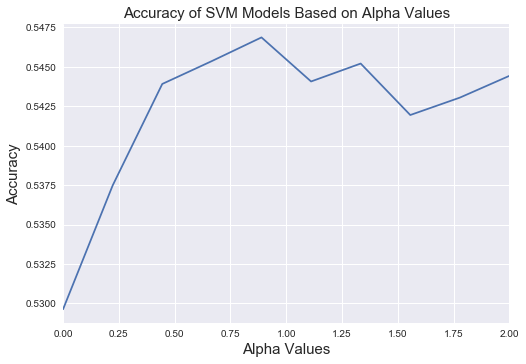

In [25]:
n_splits = 2           # number of times we will split test and training dataset
accuracies = []        # array to hold accuracy to take average of at the end
final_accuracies = {}  # list of final accuracies

# Now for each value of alpha and for each train/ test split run logistic regression
for testable in np.linspace(0.0001, 2, 10):
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = support_vector_machine_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            alpha=testable
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy: %.12f' % (np.mean(accuracies)))
    final_accuracies[testable] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

# Plot the final accuracy for each value of Alpha
plt.title('Accuracy of SVM Models Based on Alpha Values', fontsize=15)
plt.xlabel('Alpha Values', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot();

Final average accuracy: 0.512974778401
Final average accuracy: 0.520286472830
Final average accuracy: 0.518020525557
Final average accuracy: 0.520527341241
Final average accuracy: 0.522485333790
Final average accuracy: 0.523619377953
Final average accuracy: 0.522676805060
Final average accuracy: 0.523688070055
Final average accuracy: 0.522780799041
Final average accuracy: 0.522892133773


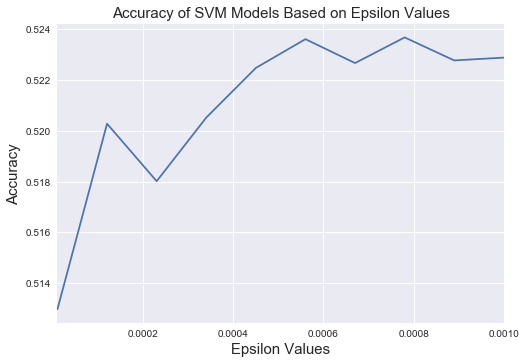

In [21]:
n_splits = 2           # number of times we will split test and training dataset
accuracies = []        # array to hold accuracy to take average of at the end
final_accuracies = {}  # list of final accuracies

# Now for each value of epsilon and for each train/ test split run logistic regression
for testable in np.linspace(0.00001, .001, 10):
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = support_vector_machine_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            epsilon=testable
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy: %.12f' % (np.mean(accuracies)))
    final_accuracies[testable] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

# Plot the final accuracy for each value of epsilon
plt.title('Accuracy of SVM Models Based on Epsilon Values', fontsize=15)
plt.xlabel('Epsilon Values', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot();

# L1 VS L2
We further compared accuracy based on L1 or L2 penalty, where we found L1, the error, is slightly more accurate than L2, the squared error. Which is interesting because typically L2 is better for minimizing error than L1. We think this is because we have about 2000 variables and did not go through and check if every one made sense.  Since L1 acts as a built in feature selection by giving weights nearly 0, this could be why our L1 is better than L2.  This is also a concern for overfitting the model but we will continue as our metric goal here is to maximize accuracy.

Final average accuracy for l1 : 0.539031387830
Final average accuracy for l2 : 0.533978503832


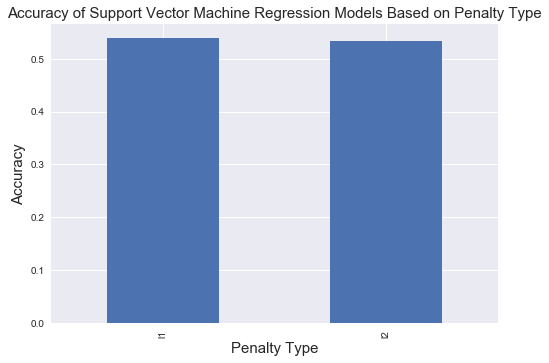

In [23]:
n_splits = 2
accuracies = []
final_accuracies = {}

for penalty in ['l1', 'l2']:
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

        yhat, _ = support_vector_machine_model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            penalty=penalty
        )
        
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)

    print('Final average accuracy for %s : %.12f' % (penalty, np.mean(accuracies)))
    final_accuracies[penalty] = np.mean(accuracies)
    
final_accuracies = pd.Series(final_accuracies)

plt.title('Accuracy of Support Vector Machine Regression Models Based on Penalty Type', fontsize=15)
plt.xlabel('Penalty Type', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

final_accuracies.plot(kind='bar');

# Compare

In [24]:
data = [[.55, 2000], [.57, 4000]]
table = pd.DataFrame(data, columns=['Accuracy', 'Time it takes'], index=['Logistic Regression', 'Support Vector Machine'])
print('Compare result ot the two models')
table

Compare result ot the two models


,Accuracy,Time it takes
Logistic Regression,0.55,2000
Support Vector Machine,0.57,4000


<a id="Advantages"></a>
<a href="#top">Back to Top</a>
## Advantages of Each Model
<b>[10 points]</b>

<i>
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail. 
</i>

## Advantages in accuracy

## Advantages in time and efficiency

SVC with a linear kernal calculates the distance between each point in the dataset.  Thus, the run time is essentially number of features multiplied by the number of observations squared.  In other words, longer than the patience of some team members to watch it complete and is the slowest method we used.

As mentioned above this was improved by LinearSVC because it is implemented using liblinear which uses a linear SVC and a logistic regression.  This means run time is log linear times linear which is better than SVC.

Logistic regression uses the liblinear library and uses a one vs the rest algorithm.  This means that the run time is in log linear time, improving the efficiency from SVC functions.

SGDClassifier is fastest and arguably linear, which to a software engineer a matrix can only run in n * m for n the number of features and m the number of observations.   It's convergence to a solution depending on the loss setting means it uses only a subset of the dataset also improving time.

In terms of our dataset, we have about 2000 features which is a sparse dataset.  Logistic regression is fast but SGD is the winner on time efficiency for us.  However, one should consider the accuracy and time tradeoff together.  

# TO DO: conclusion of time vs accuracy tradeoff what model do we like best?

<a id="Feature"></a>
<a href="#top">Back to Top</a>
## Feature Importance
<b>[30 points]</b>
    
<i>
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</i>

# Logistic Regression Feature Importance

After scaling the continuous variables, the feature importance showed that propertyzoningdesc and propertycountylandusecode for multiple counties showed the most importance for predicting logerror. This might be due to the fact that neighborhoods based on location highly dictate the sales price of a property. Tax was also a big factor. Perhaps the more land owners pay for property tax could better predict property value because more amenities could be added for a richer neighborhood than that for a poorer.

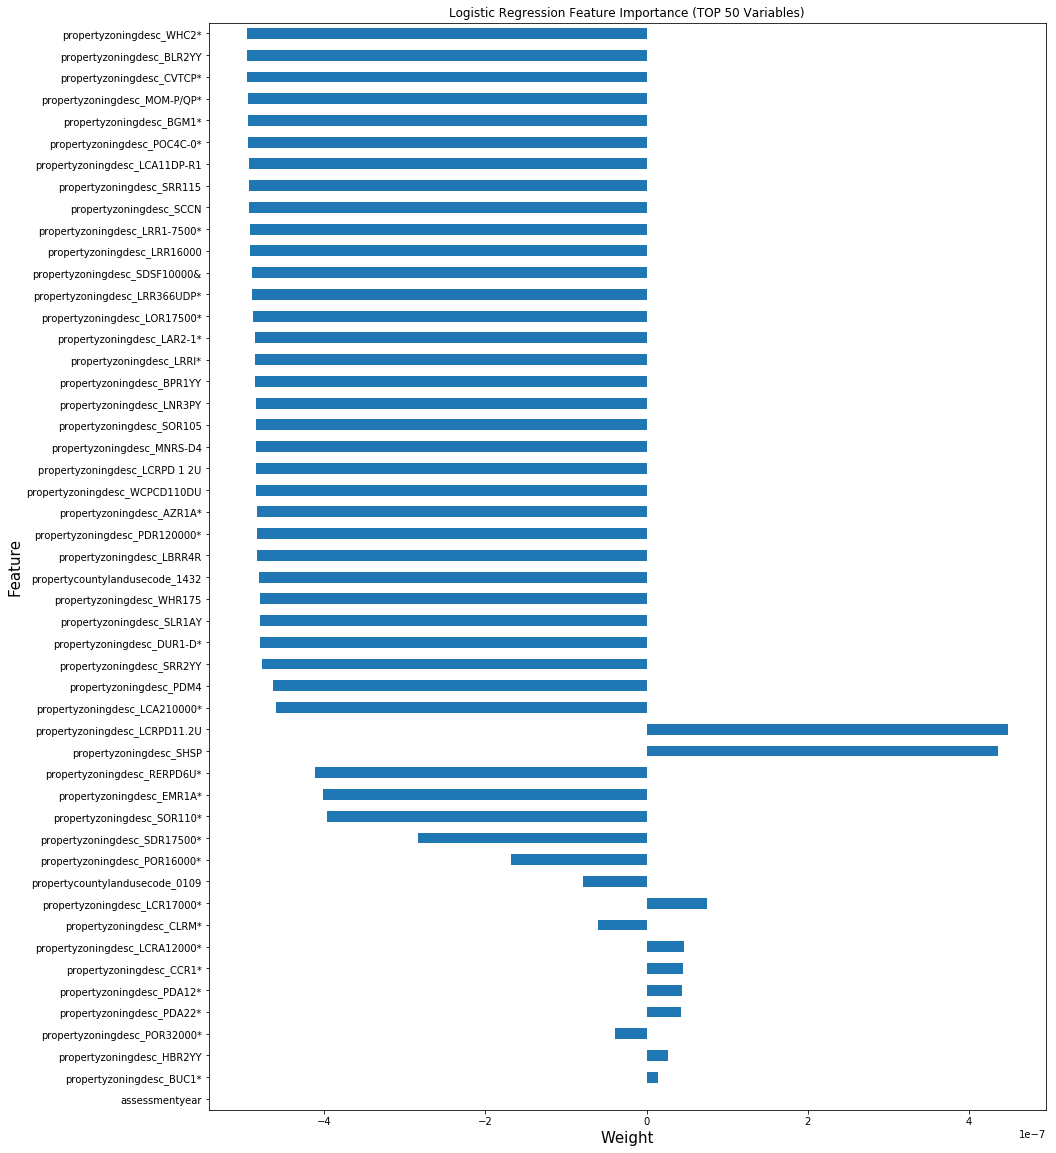

In [21]:
_, clf = logistic_regression_model(X_train=X, y_train=y, X_test=X)

abs_coefs = np.abs(clf.coef_[0])
top_50_vars = pd.Series(abs_coefs, index=X.columns).sort_values().index[:50]

importance_top_50 = pd.Series(clf.coef_[0], index=X.columns).loc[top_50_vars]

fig, ax = plt.subplots(figsize=(15, 20))
importance_top_50.plot(kind='barh', ax=ax)
plt.title('Logistic Regression Feature Importance (TOP 50 Variables)')
plt.xlabel('Weight', fontsize=15)
plt.ylabel('Feature', fontsize=15);

<a id="Insights"></a>
<a href="#top">Back to Top</a>
## Insights
<b>[10 points]</b>

<i>
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model — then analyze the support vectors from the subsampled dataset. 
</i>

# Insights from SVM Model

We used support vectors for gradient descent to find the optimal accuracy of the SVM model.

In [23]:
X.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt',
       ...
       'propertyzoningdesc_WVRPD40000', 'propertyzoningdesc_WVRPD4OOOO',
       'propertyzoningdesc_WVRPD56*', 'propertyzoningdesc_WVRR',
       'propertyzoningdesc_WVRR1-RPD1', 'zipcode_type_PO BOX',
       'zipcode_type_STANDARD', 'zipcode_type_UNIQUE',
       'location_type_NOT ACCEPTABLE', 'location_type_PRIMARY'],
      dtype='object', length=2107)

In [30]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', max_iter=20)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf.fit(X_scaled, y)

# this hold the indexes of the support vectors
clf.support_

# this holds a subset of the data which is used for support vectors
clf.support_vectors_
support_vectors = pd.DataFrame(clf.support_vectors_, columns=X.columns)

# get number of support vectors for each class
print('Nubmer of support vectros for each feature:', clf.n_support_)

Nubmer of support vectros for each feature: [1 1]


<a href="#top">Back to Top</a>
# References:

- Kernels from Kaggle competition: https://www.kaggle.com/c/zillow-prize-1/kernels
- Scikitlearn logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikitlearn linear SVC: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Stackoverflow pandas questions: https://stackoverflow.com/questions/tagged/pandas
- Scikitlearn SDGClassfier: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
